# Testing of the computed control strategy

In [1]:
%matplotlib widget
# from IPython.display import display, Math, SVG
import matplotlib.pyplot as plt

import numpy as np
import control as ctrl
from utils import simulate_full_state_feedback_arx_closed_loop

In [2]:
# stack 2nd order model
dt = 1 # 1 sec sampling
a0 = 0.007321
a1 = -0.00535
b0 = 0.3476
b1 = -1.345
b2 = 1
num = [a1, a0]
den = [b2, b1, b0]
stack_tf = ctrl.tf(num, den,dt)
stack_tf

TransferFunction(array([-0.00535 ,  0.007321]), array([ 1.    , -1.345 ,  0.3476]), 1)

In [3]:
np.array(stack_tf.den).squeeze()[1:]

array([-1.345 ,  0.3476])

In [4]:
# State Space model
stack_ss_auto = ctrl.tf2ss(stack_tf)
stack_ss_auto

StateSpace(array([[ 1.34500000e+00,  3.47600000e-01],
       [-1.00000000e+00, -4.27682108e-17]]), array([[-1.],
       [ 0.]]), array([[0.00535 , 0.007321]]), array([[0.]]), 1)

In [5]:
# State Space model, considering the handmade conversion
A = np.array([[0,1], [-b0,-b1]])
B = np.array([[-a0/b0], [a1]])
C = np.array([0, 1])
D = np.array(0)
stack_ss = ctrl.StateSpace(A, B, C, D, dt)
stack_ss

StateSpace(array([[ 0.    ,  1.    ],
       [-0.3476,  1.345 ]]), array([[-0.02106157],
       [-0.00535   ]]), array([[0., 1.]]), array([[0.]]), 1)

In [6]:
# validation of the state space model
t_end = 1500
t_tf, y_tf = ctrl.step_response(stack_tf, T=t_end)
t_ss_auto, y_ss_auto = ctrl.step_response(stack_ss_auto, T=t_end)
t_ss, y_ss = ctrl.step_response(stack_ss, T=t_end)

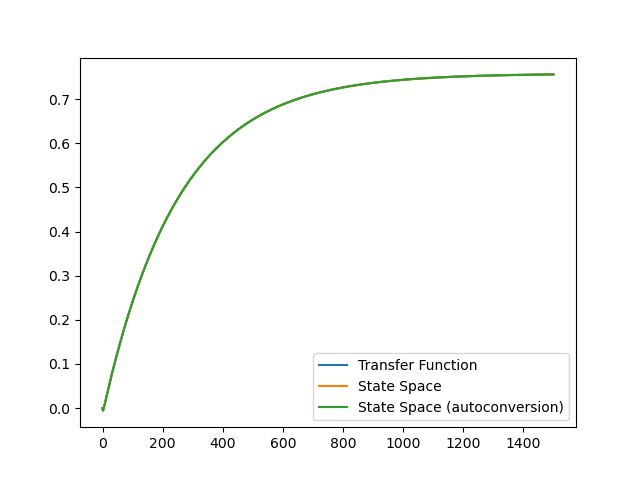

In [7]:
# plotting the results
fig, ax = plt.subplots()
ax.plot(t_tf, y_tf, label='Transfer Function')
ax.plot(t_ss, y_ss, label='State Space')
ax.plot(t_ss_auto, y_ss_auto, label='State Space (autoconversion)')
ax.legend()

In [8]:
# full state feedback gain
K = np.array([[-1.40858406,  4.03174207, -0.01573826]])

In [9]:
K[:,:2].shape

(1, 2)

In [10]:
# close loop of the state space model without integral action
close_loop_model_ss = ctrl.StateSpace(A - B@K[:,:2], B, C, D, dt)

In [11]:
# close loop of the state space model with integral action
A_int = np.vstack(( np.hstack((A, np.zeros((2,1)))), np.array([0, -dt, 1]) ))
B_int = np.vstack((B, 0))
C_int = np.hstack((C, 0))
B_new = np.array([[0], [0], [dt]])
close_loop_model_ss_int = ctrl.StateSpace(A_int - B_int@K, B_new, C_int, D, dt)
close_loop_model_u_ss_int = ctrl.StateSpace(A_int - B_int@K, B_new, -K, D, dt)

In [12]:
# evaluation of the close loop state space model
y_des = 180
t_ss_int, y_ss_int = ctrl.step_response(y_des*close_loop_model_ss_int, T=t_end)
_, u_ss_int = ctrl.step_response(y_des*close_loop_model_u_ss_int, T=t_end)

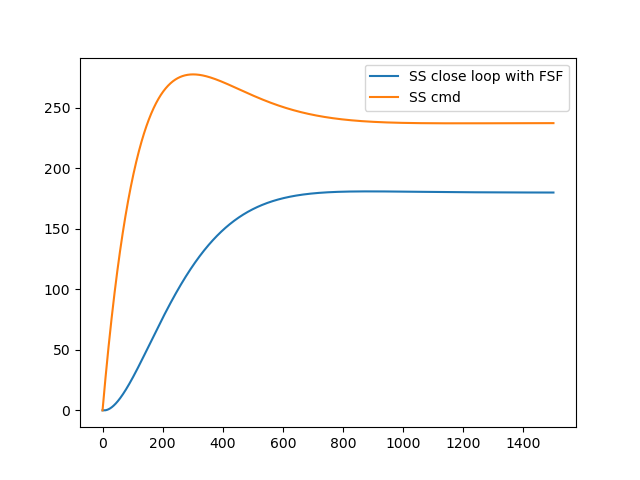

In [13]:
# plotting the close loop results
fig, ax = plt.subplots()
ax.plot(t_ss_int, y_ss_int, label='SS close loop with FSF')
ax.plot(t_ss_int, u_ss_int, label='SS cmd')
ax.legend()

In [44]:
err = y_des - y_ss_int
derr = np.gradient(err, t_ss_int)
final_err = np.mean(err[-10:])
t_err_last_thresh = t_ss_int[np.where(np.abs(err) >= 0.05*y_des)[0][-1]] # 5% settling time
t_derr_stable = t_ss_int[np.where(np.abs(derr) >= 0.05*np.abs(np.mean(derr)))[0][-1]]

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(t_ss_int, err, label='error')
ax[0].plot(t_ss_int[np.abs(err) < 0.05*y_des], err[np.abs(err) < 0.05*y_des], 'o', label='5% settling time')
ax[1].plot(t_ss_int, derr, label='derivative of error')
ax[1].plot(t_ss_int[np.abs(derr) < 0.05*np.abs(np.mean(derr))], derr[np.abs(derr) < 0.05*np.abs(np.mean(derr))], 'o', label='5% settling time')
ax[0].legend()

print("Settling time: {} s, {} s".format(t_err_last_thresh, t_derr_stable))

Settling time: 543.0 s, 805.0 s


In [14]:
# numerical simulation using the coefficient of the ARX model
t_sim = np.arange(0,t_end,dt)
x = np.zeros((3,1))
init_temp = 0
y = init_temp*np.ones((2,1)) # initial condition (temperature), y[1] = y(k-1), y[0] = y(k)
u = init_temp*np.ones((2,1)) # initial condition (command signal)
a_coeff = np.array([[a1,a0]])
b_coeff = np.array([[b1,b0]])
y_record = []
u_record = []
t_last = 0

for t in t_sim:
    # compute the state of the system
    x[0] = y[1] - a0/b0 * u[1]
    x[1] = y[0]
    x[2] = x[2] + (t - t_last)*(y_des - y[0])
    # compute the command signal
    u[0] = -K@x
    # if t > 0:
    #     u[0] = 1
    y_record.append(y[0])
    u_record.append(u[0])
    # compute the temperature using the ARX model
    y_out = a_coeff@u - b_coeff@y 
    u = np.roll(u, 1)
    y = np.roll(y, 1)
    y[0] = y_out
    t_last = t

In [15]:
y_record = np.array(y_record)
u_record = np.array(u_record)

In [16]:
# numerical simulation using the coefficient of the ARX model with a saturation
# FSFThreshold = 200
x = np.zeros((3,1))
y_des = 180
init_temp = 0
y_init = init_temp
u_init = init_temp
y = init_temp*np.ones((2,1)) # initial condition (temperature), y[1] = y(k-1), y[0] = y(k)
u = init_temp*np.ones((2,1)) # initial condition (command signal)
a_coeff = np.array([[a1,a0]])
b_coeff = np.array([[b1,b0]])
y_record_thresh = []
u_record_thresh = []
t_last = 0
u_max = 250
u_min = 2

for t in t_sim:
    # compute the state of the system without the integral action
    x[0] = y[1] - y_init - a0/b0 * (u[1] - u_init)
    x[1] = y[0] - y_init
    # if (y_des - y[0]) > FSFThreshold :
    #     u[0] = y_des
    #     init_temp = y[0]
    # compute the integral state of the system
    x[2] = x[2] + (t - t_last)*(y_des - y[0])
    # compute the command signal
    u[0] = -K@x
    # saturation of the cmd signal
    if u[0]  > u_max:
        u[0] = u_max
    elif u[0] < u_min:
        u[0] = u_min
    y_record_thresh.append(y[0])
    u_record_thresh.append(u[0])
    # compute the temperature using the ARX model
    y_out = a_coeff@u - b_coeff@y 
    u = np.roll(u, 1)
    y = np.roll(y, 1)
    y[0] = y_out
    t_last = t

y_record_thresh = np.array(y_record_thresh)
u_record_thresh = np.array(u_record_thresh)

In [17]:
# numerical simulation using the coefficient of the ARX model with a saturation and antiwindup
x = np.zeros((3,1))
y_des = 180
init_temp = 0
y_init = init_temp
u_init = init_temp
y = init_temp*np.ones((2,1)) # initial condition (temperature), y[1] = y(k-1), y[0] = y(k)
u = init_temp*np.ones((2,1)) # initial condition (command signal)
a_coeff = np.array([[a1,a0]])
b_coeff = np.array([[b1,b0]])
y_record_windup = []
u_record_windup = []
t_last = 0
u_max = 250
u_min = 2
Kt = K[0,2]
is_u_sat = False

for t in t_sim:
    # compute the state of the system without the integral action
    x[0] = y[1] - y_init - a0/b0 * (u[1] - u_init)
    x[1] = y[0] - y_init
    # compute the integral state of the system
    if is_u_sat == False:
        x[2] = x[2] + (t - t_last)*(y_des - y[0])
    # compute the command signal
    u[0] = -K@x
    is_u_sat = False
    if u[0] > u_max:
        # x[2] = x[2] - Kt*(u[0] - u_max)*(t - t_last) # anti windup
        u[0] = u_max
        is_u_sat = True
    elif u[0] < u_min:
        # x[2] = x[2] - Kt*(u[0] - u_min)*(t - t_last) # anti windup
        u[0] = u_min
    y_record_windup.append(y[0])
    u_record_windup.append(u[0])
    # compute the temperature using the ARX model
    y_out = a_coeff@u - b_coeff@y 
    u = np.roll(u, 1)
    y = np.roll(y, 1)
    y[0] = y_out
    t_last = t

y_record_windup = np.array(y_record_windup)
u_record_windup = np.array(u_record_windup)

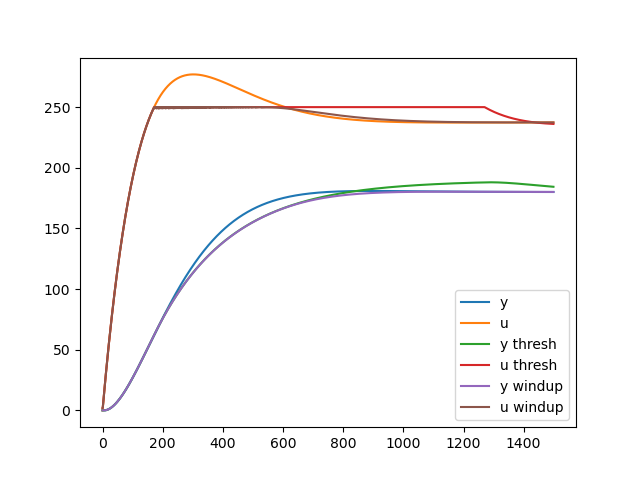

In [18]:
# plotting the results
fig, ax = plt.subplots()
ax.plot(t_sim, y_record, label='y')
ax.plot(t_sim, u_record, label='u')
ax.plot(t_sim, y_record_thresh, label='y thresh')
ax.plot(t_sim, u_record_thresh, label='u thresh')
ax.plot(t_sim, y_record_windup, label='y windup')
ax.plot(t_sim, u_record_windup, label='u windup')
# ax.plot(t_ss_int, y_ss_int, linestyle='dashed', label='SS close loop with FSF')
# ax.plot(t_ss_int, u_ss_int, linestyle='dashed', label='SS cmd')
ax.legend()

In [19]:
t_max = 1500
K_new = K.copy()
y0 = 100
u0 = 100
# reference without saturation
t, y, u = simulate_full_state_feedback_arx_closed_loop(stack_tf, K, target=180, t_max=t_max, 
    cmd_bound=np.array([-np.inf, np.inf]), y0=y0, u0=u0, is_integral_action=True, is_windup=True)
# plotting the results
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(t, y, label='y')
ax[0].plot(t, 180*np.ones(t.shape), 'k', linestyle='dashed', label='target')
ax[1].plot(t, u, label='u')
ax[0].set_title("Output")
ax[1].set_title("Command")
ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("Temperature (°c)")
ax[1].set_ylabel("Temperature (°c)")
# reference with saturation and windup
t, y, u = simulate_full_state_feedback_arx_closed_loop(stack_tf, K, target=180, t_max=t_max, 
    cmd_bound=np.array([0, 250]), y0=y0, u0=u0, is_integral_action=True, is_windup=True)
# plotting the results
ax[0].plot(t, y, label='y sat')
ax[1].plot(t, u, label='u sat')
# make variation to the first K gains
for i in range(10):
    K_new[0,0] = K[0,0]+(i+1)*0.20*K[0,0]
    t, y, u = simulate_full_state_feedback_arx_closed_loop(stack_tf, K_new, target=180, t_max=t_max, 
        cmd_bound=np.array([0, 250]), y0=y0, u0=u0, is_integral_action=True, is_windup=True)
    ax[0].plot(t, y, linestyle='dashed')
    ax[1].plot(t, u, linestyle='dashed', label='K[0]'+str(int(K_new[0,0])))
fig.legend()
fig.suptitle('Comparison of K[0] gain increase')

Text(0.5, 0.98, 'Comparison of K[0] gain increase')

In [26]:
np.mean(y[-1:])

189.06369083005245

In [64]:
K_new = K.copy()
# reference without saturation
t, y, u = simulate_full_state_feedback_arx_closed_loop(stack_tf, K, target=180, t_max=t_max, 
    cmd_bound=np.array([-np.inf, np.inf]), y0=0, u0=0, is_integral_action=True, is_windup=True)
# plotting the results
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(t, y, label='y')
ax[0].plot(t, 180*np.ones(t.shape), 'k', linestyle='dashed', label='target')
ax[1].plot(t, u, label='u')
ax[0].set_title("Output")
ax[1].set_title("Command")
ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("Temperature (°c)")
ax[1].set_ylabel("Temperature (°c)")
# reference with saturation and windup
t, y, u = simulate_full_state_feedback_arx_closed_loop(stack_tf, K, target=180, t_max=t_max, 
    cmd_bound=np.array([0, 250]), y0=0, u0=0, is_integral_action=True, is_windup=True)
# plotting the results
ax[0].plot(t, y, label='y sat')
ax[1].plot(t, u, label='u sat')
# make variation to the first K gains
for i in range(10):
    K_new[0,1] = K[0,1]-(i+1)*0.20*K[0,1]
    t, y, u = simulate_full_state_feedback_arx_closed_loop(stack_tf, K_new, target=180, t_max=t_max, 
        cmd_bound=np.array([0, 250]), y0=0, u0=0, is_integral_action=True, is_windup=True)
    ax[0].plot(t, y, linestyle='dashed')
    ax[1].plot(t, u, linestyle='dashed', label='K[0]'+str(int(K_new[0,1])))
fig.legend()
fig.suptitle('Comparison of K[1] gain reduction')

Text(0.5, 0.98, 'Comparison of K[1] gain reduction')

In [80]:
# numerical simulation for non null initial conditions
t_sim = np.arange(0,t_end,dt)
x = np.zeros((3,1))
init_temp = 25
y_des = 50
y = init_temp*np.ones((2,1)) # initial condition (temperature), y[1] = y(k-1), y[0] = y(k)
u = init_temp*np.ones((2,1)) # initial condition (command signal)
a_coeff = np.array([[a1,a0]])
b_coeff = np.array([[b1,b0]])
y_record = []
u_record = []
t_last = 0

for t in t_sim:
    # compute the state of the system
    x[0] = y[1]-init_temp - a0/b0 * (u[1]-init_temp)
    x[1] = y[0]-init_temp
    x[2] = x[2] + (t - t_last)*(y_des - y[0])
    # compute the command signal
    u[0] = -K@x
    if u[0] < 0:
        u[0] = 0
    # if t > 0:
    #     u[0] = 1
    y_record.append(y[0])
    u_record.append(u[0])
    # compute the temperature using the ARX model
    y_out = a_coeff@u - b_coeff@y 
    u = np.roll(u, 1)
    y = np.roll(y, 1)
    y[0] = y_out
    t_last = t

In [81]:
# plotting the results
fig, ax = plt.subplots()
ax.plot(t_sim, y_record, label='y')
ax.plot(t_sim, u_record, label='u')
ax.legend()

In [234]:
# cartridge model (discrete)
# a_coeff_cart_continuous = np.array([154])
# b_coeff_cart_continuous = np.array([25.25, 10.05, 1])
# cart_cont_model = ctrl.TransferFunction(a_coeff_cart_continuous, b_coeff_cart_continuous)
# cart_model = ctrl.c2d(cart_cont_model, dt/10, 'zoh')
# cart_model
cart_model = ctrl.TransferFunction([0.00059959, 0.00058497], [ 1., -1.92728089, 0.92860291], dt/10)

In [204]:
# PID model (discrete)
Kp = 2.23
Ti = 10.65
Td = 2.66
N = 10
pid_contiunous_model = ctrl.tf([Kp*Td*Ti*(1 + N), Kp*(N*Ti +Td), Kp*N], [Td*Ti, N*Ti, 0])
pid_model = ctrl.c2d(pid_contiunous_model, dt/10, 'tustin')
pid_model

TransferFunction(array([ 21.01198847, -41.29402864,  20.28866643]), array([ 1.       , -1.6835443,  0.6835443]), 0.1)

In [232]:
# simulation with internal loop (cartridge)
t_sim_2 = np.arange(0,t_end,dt/10)
x = np.zeros((3,1))
y_des = 10
# initial condition
y = np.zeros((2,1)) # temperature of the stack, y[1] = y(k-1), y[0] = y(k)
w = np.zeros((2,1)) # temperature of the cartridge
u = np.zeros((2,1)) # FSF command signal (for main loop)
v = np.zeros((2,1)) # PID command signal (for cartridge)
e = np.zeros((3,1)) # error (for PID loop)
# stack model
a_coeff = np.array([[a1,a0]])
b_coeff = np.array([[b1,b0]])
# cartridge model
a_coeff_cart = np.array(cart_model.num[0])
b_coeff_cart = np.array([cart_model.den[0][0][1:]])
# # PID discrete parameters
# a_coeff_pid = np.array(pid_model.num[0])
# b_coeff_pid = np.array([pid_model.den[0][0][1:]])
# PID parameters
Kp = 1
Ti = 0.1
Td = 1
e_sum = 0 # integral of the error
e_last = 0 # last error

y_record_2 = []
u_record_2 = []
w_record_2 = []
v_record_2 = []

t_last = 0

for t in t_sim_2:
    if np.mod(t, 1) == 0:
        # compute the new state of the system (FSF)
        x[0] = y[1] - a0/b0 * w[1]
        x[1] = y[0]
        x[2] = x[2] + (t - t_last)*(y_des - y[0])
        # compute the target command for the cartidge
        u[0] = -K@x

    w_record_2.append(w[0])
    v_record_2.append(v[0])
    # cartridge PID inner loop
    # using continuous form of the PID
    e = u[0] - w[0]
    e_sum = e_sum + e*(dt/10)
    v[0] = Kp*e + Kp/Ti*e_sum*dt + Kp*Td*(e - e_last)/(dt/10)
    e_last = e
    # using discrete form of the PID
    # e[0] = u[0] - w[0]
    # v_out = a_coeff_pid@e + b_coeff_pid@v
    # e = np.roll(e, 1)
    # v[0] = v_out

    # compute the cartidge temperature using the ARX model
    w_out = a_coeff_cart@v - b_coeff_cart@w
    w = np.roll(w, 1)
    v = np.roll(v, 1)
    w[0] = w_out

    # compute the satck temperature using the ARX model at the lower rate
    if np.mod(t, 1) == 0:
        y_record_2.append(y[0])
        u_record_2.append(u[0])
        y_out = a_coeff@u - b_coeff@y 
        u = np.roll(u, 1)
        y = np.roll(y, 1)
        y[0] = y_out
        t_last = t

In [233]:
# plotting the results
fig, ax = plt.subplots()
ax.plot(t_sim, y_record_2, label='y')
ax.plot(t_sim, u_record_2, label='u')
ax.plot(t_sim_2, w_record_2, label='w')
ax.plot(t_sim_2, v_record_2, label='v')
ax.legend()

In [165]:
[cart_model.den[0][0][1:]]

[array([-1.96059146,  0.96097971])]

In [151]:
# import sympy as sym

# # symbolic variables
# s = sym.symbols('s')
# Ti = sym.symbols('T_i')
# Td = sym.symbols('T_d')
# Kp = sym.symbols('K_p')
# N = sym.symbols('N')

# model = Kp * (1 + 1/Ti/s + Td*s/(1+Td/N*s))
# # put to the same denominator
# model = sym.simplify(sym.together(model))
# # regroup using s as the laplace variable
# sym.collect(model.expand(), s)


K_p*N/(N*T_i*s + T_d*T_i*s**2) + s**2*(K_p*N*T_d*T_i/(N*T_i*s + T_d*T_i*s**2) + K_p*T_d*T_i/(N*T_i*s + T_d*T_i*s**2)) + s*(K_p*N*T_i/(N*T_i*s + T_d*T_i*s**2) + K_p*T_d/(N*T_i*s + T_d*T_i*s**2))